# Neccessary Packages

In [1]:
import os
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchinfo

# Load the image dataset and transforms it into tensor

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
        
}

data_dir = 'shirt_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
# next(iter(dataloaders['test']))

# Visualize few images

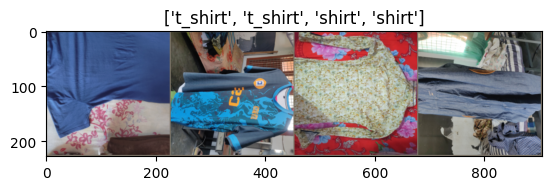

['shirt', 't_shirt']


In [3]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt
def imshow(input_image, title=None):
    input_image = input_image.numpy().transpose(1, 2, 0) #Make (224, 224, 3) into (3, 224, 224)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_image = std*input_image + mean
    input_image = np.clip(input_image, 0, 1)
    plt.imshow(input_image)
    if title is not None:
        plt.title(title)
    plt.pause(1)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
out[0].shape, inputs[0].shape
class_names = image_datasets['train'].classes
imshow(out, title=[class_names[x] for x in classes])
print(class_names)


# Training the model, scheduling the learnig rate and saving the best model

In [4]:
import time
from tempfile import TemporaryDirectory
def train_model(model, criterion, optimizer, scheduler, epochs=5):
    start_time = time.time()
    
    # Temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pth')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        for epoch in range(epochs):
            print(f'Epoch {epoch}/{epochs-1}')
            print('-'*10)
            
            #Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase =='train':
                    model.train()
                else:
                    model.eval()
                
                #loss for accuracy calculation
                running_loss = 0.0
                running_correct = 0.0

                #Iteration over the data
                for inputs, classes in dataloaders[phase]:
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase=='train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, classes)
                        
                        #backward and optimize the parameters if in training phase
                        if phase=='train':
                            loss.backward()
                            optimizer.step()
                    
                    #Statistics
                    running_loss += loss.item()*inputs.size(0)
                    running_correct += torch.sum(preds==classes.data)
                
                if phase=='train':
                    scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_correct.double() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                if phase=='val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            print() #Just a new line
        
        time_elapsed = time.time() - start_time
        print(f'Training Complete in {time_elapsed//60} minutes {time_elapsed%60} secs')
        print(f'Best val Acc: {best_acc}')
        
        model.load_state_dict(torch.load(best_model_params_path))
    return model

# Testing Phase

In [5]:
def testing_model(model):
    model.eval()
    running_correct = 0.0
    with torch.no_grad():
        for inputs, classes in dataloaders['test']:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_correct += torch.sum(preds==classes.data)
    test_acc = running_correct.double() / dataset_sizes['test']
    print()
    print(f'Test Accuracy: {test_acc:.4f}')
    # return test_acc

# VGG16 with pretrained weights in the convolution block and customiztion of fully connected layers

In [6]:
model = models.vgg16(pretrained=True)
torchinfo.summary(model, input_size=(1, 3, 224, 224))

d:\books\course\2-2\CSE2252 Software Development Lab II\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
d:\books\course\2-2\CSE2252 Software Development Lab II\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [ ]:
model.state_dict()

# Freeze the weights of feature layers

In [7]:
for name, param in model.named_parameters():
    param.requires_grad = False
num_of_features = model.classifier[0].in_features
classifier = nn.Sequential(
    nn.Linear(num_of_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2),
)
model.classifier = classifier
for name, param in model.named_parameters():
    print(f'{name}: {param.requires_grad}')

features.0.weight: False
features.0.bias: False
features.2.weight: False
features.2.bias: False
features.5.weight: False
features.5.bias: False
features.7.weight: False
features.7.bias: False
features.10.weight: False
features.10.bias: False
features.12.weight: False
features.12.bias: False
features.14.weight: False
features.14.bias: False
features.17.weight: False
features.17.bias: False
features.19.weight: False
features.19.bias: False
features.21.weight: False
features.21.bias: False
features.24.weight: False
features.24.bias: False
features.26.weight: False
features.26.bias: False
features.28.weight: False
features.28.bias: False
classifier.0.weight: True
classifier.0.bias: True
classifier.3.weight: True
classifier.3.bias: True


In [8]:
#Train the model
torch.manual_seed(42)
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
model_fz = train_model(model, criterion, optimizer, exp_lr_scheduler, epochs=9)

#Testing
testing_model(model)

Epoch 0/8
----------
train Loss: 0.5607 Acc: 0.7277
val Loss: 0.2280 Acc: 0.9250

Epoch 1/8
----------
train Loss: 0.3791 Acc: 0.8431
val Loss: 0.1696 Acc: 0.9250

Epoch 2/8
----------
train Loss: 0.2544 Acc: 0.8802
val Loss: 0.3743 Acc: 0.8917

Epoch 3/8
----------
train Loss: 0.2329 Acc: 0.9041
val Loss: 0.1622 Acc: 0.9167

Epoch 4/8
----------
train Loss: 0.1600 Acc: 0.9455
val Loss: 0.1680 Acc: 0.9167

Epoch 5/8
----------
train Loss: 0.1376 Acc: 0.9412
val Loss: 0.1666 Acc: 0.9417

Epoch 6/8
----------
train Loss: 0.2133 Acc: 0.9237
val Loss: 0.1792 Acc: 0.9417

Epoch 7/8
----------
train Loss: 0.1654 Acc: 0.9390
val Loss: 0.1482 Acc: 0.9417

Epoch 8/8
----------
train Loss: 0.1862 Acc: 0.9281
val Loss: 0.1556 Acc: 0.9417

Training Complete in 28.0 minutes 21.837456703186035 secs
Best val Acc: 0.9416666666666667

Test Accuracy: 0.8829


# VGG16 with pretrained parameters except the last convolution block

In [9]:
model_without_last_cnv = models.vgg16(pretrained=True)
num_of_features = model_without_last_cnv.classifier[0].in_features

param_indices = []
for name, param in model_without_last_cnv.named_parameters():
    if 'features.28' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

classifier = nn.Sequential(
    nn.Linear(num_of_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2),
)

model_without_last_cnv.classifier = classifier
# for name, param in model_without_last_cnv.named_parameters():
#     print(f'{name}: {param.requires_grad}')
torchinfo.summary(model_without_last_cnv, input_size=(1, 3, 224, 224))
    

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

In [10]:
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_without_last_cnv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_ft = train_model(model_without_last_cnv, criterion, optimizer, exp_lr_scheduler, epochs=15)

#Testing
testing_model(model_without_last_cnv)

Epoch 0/14
----------
train Loss: 0.5067 Acc: 0.7691
val Loss: 0.2474 Acc: 0.9000

Epoch 1/14
----------
train Loss: 0.2340 Acc: 0.9020
val Loss: 0.1665 Acc: 0.9333

Epoch 2/14
----------
train Loss: 0.1542 Acc: 0.9368
val Loss: 0.4332 Acc: 0.8500

Epoch 3/14
----------
train Loss: 0.1546 Acc: 0.9499
val Loss: 0.2289 Acc: 0.9333

Epoch 4/14
----------
train Loss: 0.1043 Acc: 0.9586
val Loss: 0.1769 Acc: 0.9250

Epoch 5/14
----------
train Loss: 0.0840 Acc: 0.9651
val Loss: 0.2071 Acc: 0.9333

Epoch 6/14
----------
train Loss: 0.1229 Acc: 0.9651
val Loss: 0.2142 Acc: 0.9500

Epoch 7/14
----------
train Loss: 0.0776 Acc: 0.9695
val Loss: 0.1785 Acc: 0.9583

Epoch 8/14
----------
train Loss: 0.0776 Acc: 0.9695
val Loss: 0.2621 Acc: 0.9250

Epoch 9/14
----------
train Loss: 0.0800 Acc: 0.9739
val Loss: 0.1888 Acc: 0.9500

Epoch 10/14
----------
train Loss: 0.0587 Acc: 0.9782
val Loss: 0.1627 Acc: 0.9583

Epoch 11/14
----------
train Loss: 0.0742 Acc: 0.9739
val Loss: 0.1879 Acc: 0.9500

Ep

# VGG16 with pretrained parameters except the two last convolution blocks

In [11]:
torch.manual_seed(42)
model_without_two_last_cnv = models.vgg16()
num_of_features = model_without_two_last_cnv.classifier[0].in_features

param_indices = []
for i, (name, param) in enumerate(model_without_two_last_cnv.named_parameters()):
    if 'features.26' in name or 'features.28' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

classifier = nn.Sequential(
    nn.Linear(num_of_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2),
)

model_without_two_last_cnv.classifier = classifier
for name, param in model_without_two_last_cnv.named_parameters():
    print(f'{name}: {param.requires_grad}')

features.0.weight: False
features.0.bias: False
features.2.weight: False
features.2.bias: False
features.5.weight: False
features.5.bias: False
features.7.weight: False
features.7.bias: False
features.10.weight: False
features.10.bias: False
features.12.weight: False
features.12.bias: False
features.14.weight: False
features.14.bias: False
features.17.weight: False
features.17.bias: False
features.19.weight: False
features.19.bias: False
features.21.weight: False
features.21.bias: False
features.24.weight: False
features.24.bias: False
features.26.weight: True
features.26.bias: True
features.28.weight: True
features.28.bias: True
classifier.0.weight: True
classifier.0.bias: True
classifier.3.weight: True
classifier.3.bias: True


In [12]:
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_without_two_last_cnv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_ft = train_model(model_without_two_last_cnv, criterion, optimizer, exp_lr_scheduler, epochs=15)

#Testing
testing_model(model_without_two_last_cnv)

Epoch 0/14
----------
train Loss: 0.7009 Acc: 0.4793
val Loss: 0.6934 Acc: 0.4667

Epoch 1/14
----------
train Loss: 0.6937 Acc: 0.5229
val Loss: 0.6901 Acc: 0.4667

Epoch 2/14
----------
train Loss: 0.6934 Acc: 0.5011
val Loss: 0.6885 Acc: 0.4667

Epoch 3/14
----------
train Loss: 0.6907 Acc: 0.5294
val Loss: 0.6862 Acc: 0.4750

Epoch 4/14
----------
train Loss: 0.6858 Acc: 0.5577
val Loss: 0.6831 Acc: 0.6833

Epoch 5/14
----------
train Loss: 0.6862 Acc: 0.5577
val Loss: 0.6806 Acc: 0.6417

Epoch 6/14
----------
train Loss: 0.6877 Acc: 0.5381
val Loss: 0.6765 Acc: 0.6500

Epoch 7/14
----------
train Loss: 0.6753 Acc: 0.6231
val Loss: 0.6748 Acc: 0.6333

Epoch 8/14
----------
train Loss: 0.6723 Acc: 0.6166
val Loss: 0.6730 Acc: 0.6083

Epoch 9/14
----------
train Loss: 0.6804 Acc: 0.5664
val Loss: 0.6717 Acc: 0.6500

Epoch 10/14
----------
train Loss: 0.6772 Acc: 0.5795
val Loss: 0.6709 Acc: 0.6667

Epoch 11/14
----------
train Loss: 0.6745 Acc: 0.6122
val Loss: 0.6698 Acc: 0.6750

Ep

# VGG16 without pretrained parameters

In [13]:
torch.manual_seed(42)
model_without_weights = models.vgg16()
num_of_features = model_without_weights.classifier[0].in_features
classifier = nn.Sequential(
    nn.Linear(num_of_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2),
)
model_without_weights.classifier = classifier
for name, param in model_without_weights.named_parameters():
    print(f'{name}: {param.requires_grad}')

features.0.weight: True
features.0.bias: True
features.2.weight: True
features.2.bias: True
features.5.weight: True
features.5.bias: True
features.7.weight: True
features.7.bias: True
features.10.weight: True
features.10.bias: True
features.12.weight: True
features.12.bias: True
features.14.weight: True
features.14.bias: True
features.17.weight: True
features.17.bias: True
features.19.weight: True
features.19.bias: True
features.21.weight: True
features.21.bias: True
features.24.weight: True
features.24.bias: True
features.26.weight: True
features.26.bias: True
features.28.weight: True
features.28.bias: True
classifier.0.weight: True
classifier.0.bias: True
classifier.3.weight: True
classifier.3.bias: True


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_without_weights.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model_ft = train_model(model_without_weights, criterion, optimizer, exp_lr_scheduler, epochs=20)

#Testing
testing_model(model_without_weights)

Epoch 0/19
----------
train Loss: 0.6935 Acc: 0.5033
val Loss: 0.6947 Acc: 0.4667

Epoch 1/19
----------
train Loss: 0.6875 Acc: 0.5425
val Loss: 0.6890 Acc: 0.5917

Epoch 2/19
----------
train Loss: 0.6920 Acc: 0.5359
val Loss: 0.6802 Acc: 0.5917

Epoch 3/19
----------
train Loss: 0.6823 Acc: 0.5708
val Loss: 0.6760 Acc: 0.5917

Epoch 4/19
----------
train Loss: 0.6754 Acc: 0.5795
val Loss: 0.6293 Acc: 0.7417

Epoch 5/19
----------
train Loss: 0.6432 Acc: 0.6623
val Loss: 0.6172 Acc: 0.5917

Epoch 6/19
----------
train Loss: 0.6156 Acc: 0.6797
val Loss: 0.5743 Acc: 0.7250

Epoch 7/19
----------
train Loss: 0.5936 Acc: 0.7015
val Loss: 0.5945 Acc: 0.6250

Epoch 8/19
----------
train Loss: 0.5641 Acc: 0.7211
val Loss: 0.5809 Acc: 0.6333

Epoch 9/19
----------
train Loss: 0.5564 Acc: 0.7146
val Loss: 0.5641 Acc: 0.6583

Epoch 10/19
----------
train Loss: 0.5193 Acc: 0.7734
val Loss: 0.5472 Acc: 0.7250

Epoch 11/19
----------
train Loss: 0.5059 Acc: 0.7778
val Loss: 0.5565 Acc: 0.7167

Ep